In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir('../')
from dotenv import load_dotenv

load_dotenv('.env')

from src.utils.load_save_data import load_static_files, load_preprocessed_files
from src.utils.preprocess import preprocess_train, make_grouped_dataset

%matplotlib inline


In [2]:
os.environ.get('DATA_FOLDER')

'data/'

# Import Data

In [3]:
static_files = load_static_files()
preprocessed_files = load_preprocessed_files()

C:\Users\JosiePark\Anaconda3\envs\pe_env\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
train_preprocess = preprocessed_files['PREPROCESSED_TRAIN_DATA']
test = static_files['TEST_DATA']
items = static_files['ITEMS_DATA']
shops = static_files['SHOPS_DATA']
item_cats = static_files['ITEM_CATS_DATA']
train = static_files['TRAIN_DATA']

In [5]:
train['date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')

In [6]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


# Plots of time series

## Time Series of total sales

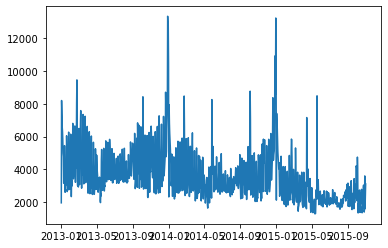

In [7]:
sales_data = train.groupby(['date'])['item_cnt_day'].sum()

plt.plot(sales_data)

## Monthly smoothed time series

In [8]:
sales_data = train.groupby(['date_block_num'])['item_cnt_day'].sum()

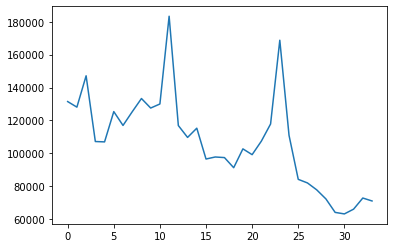

In [9]:
plt.plot(sales_data)

# Seasonality in overall time series

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')
import pylab
pylab.rcParams['figure.figsize'] = (14, 9)

In [11]:
sales_data = train.groupby(['date'])['item_cnt_day'].sum()


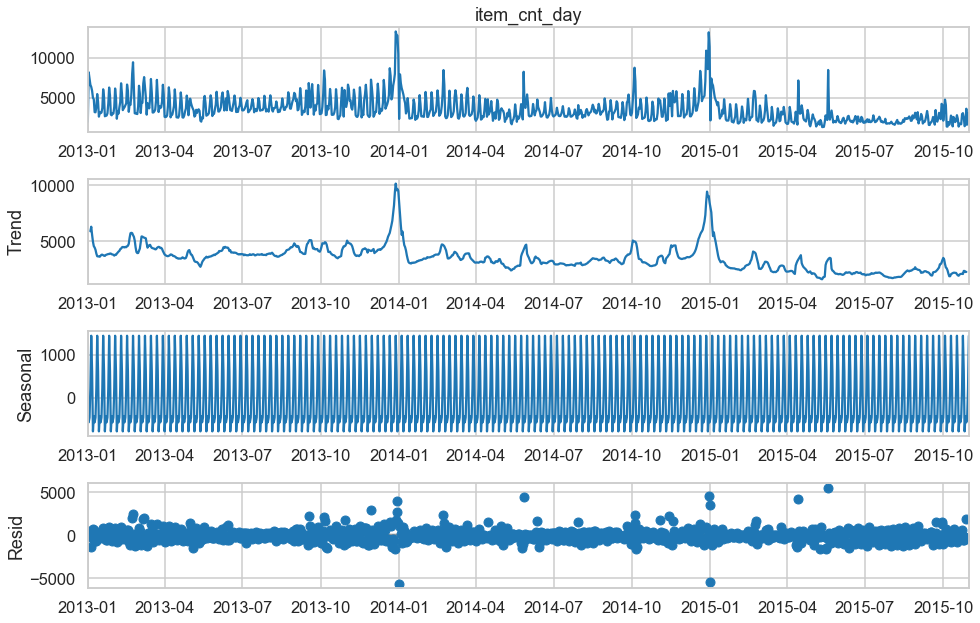

In [12]:
decomp = seasonal_decompose(sales_data, model = 'additive')
decomp.plot();


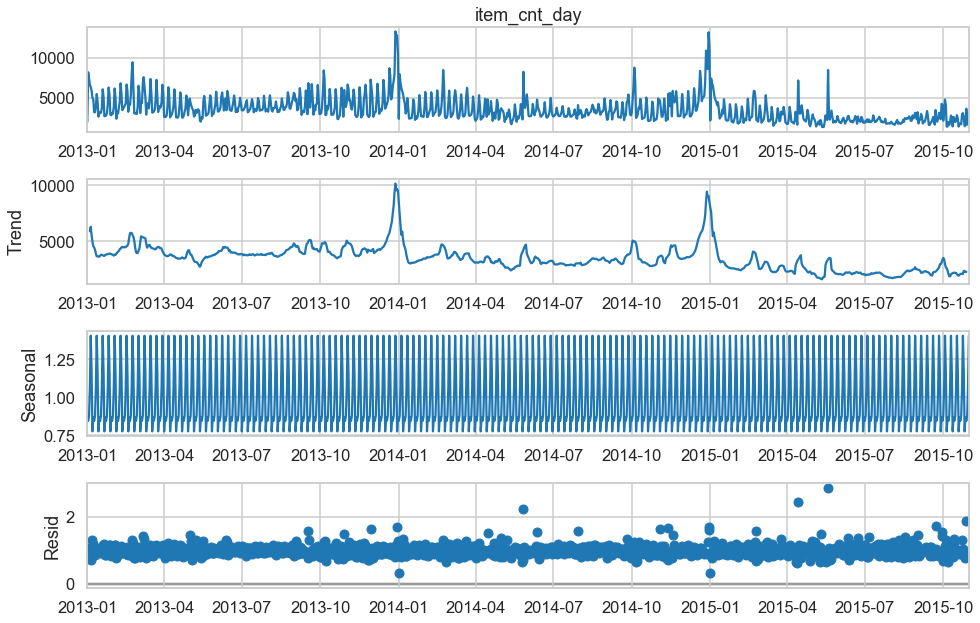

In [13]:
decomp = seasonal_decompose(sales_data, model = 'multiplicative')
decomp.plot();

In [14]:
monthly_sales_data = train.groupby(['date_block_num'])['item_cnt_day'].sum()

# Prophet seasonal decomposition

In [16]:
sales_data.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-10-22', '2015-10-23', '2015-10-24', '2015-10-25',
               '2015-10-26', '2015-10-27', '2015-10-28', '2015-10-29',
               '2015-10-30', '2015-10-31'],
              dtype='datetime64[ns]', name='date', length=1034, freq=None)

In [17]:
prophet_df = pd.DataFrame()

In [18]:
prophet_df['ds'] = sales_data.index

In [19]:
prophet_df['y'] = sales_data.values

In [20]:
prophet_df

,ds,y
0,2013-01-01,1951.0
1,2013-01-02,8198.0
2,2013-01-03,7422.0
3,2013-01-04,6617.0
4,2013-01-05,6346.0
...,...,...
1029,2015-10-27,1551.0
1030,2015-10-28,3593.0
1031,2015-10-29,1589.0
1032,2015-10-30,2274.0


In [21]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [22]:
model = Prophet(growth = 'linear', yearly_seasonality = True, weekly_seasonality = True)

In [23]:
model.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
future = model.make_future_dataframe(periods = 31)

In [25]:
forecast = model.predict(future)

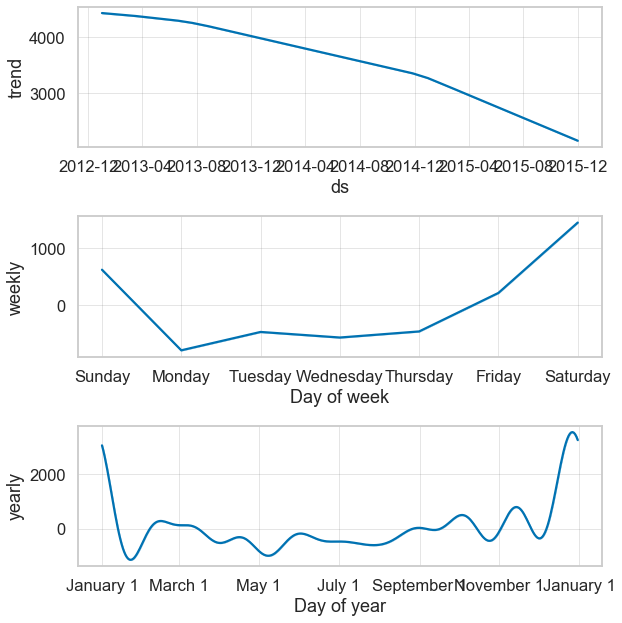

In [26]:
model.plot_components(forecast);

# examine time series at an item by item level

In [28]:
# create separate model for each 
train_preprocess.rename(columns = {'(\'item_price\', \'mean\')' : 'item_price', '(\'item_cnt_day\', \'sum\')' : 'item_cnt'}, inplace = True)

In [29]:
train_preprocess.head()

,shop_id,item_id,date_block_num,"('date', 'min')","('date', 'max')",item_price,item_cnt
114910,2,19,0,0,0,0.0,0.0
117150,2,27,0,11.01.2013,11.01.2013,2499.0,1.0
120623,2,28,0,0,0,0.0,0.0
118316,2,29,0,0,0,0.0,0.0
114602,2,32,0,0,0,0.0,0.0


In [30]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
